## Project Three: Three Body System

Initial Condition
    1. Two Stationary Stars and One Body Introduced
        init_state: Star1_p = (-100, 0) v = (0, 0)
                    Star2_p = (100, 0)  v = (0, 0)
                    Planet_p = (50, 50) v = (0, -50) 
                    
        
    2. Two Stationary Stars and Two Bodies Introduced with pretty much the same condition(chaos)
    
    3. Binary Star System with Two Bodies Introduced
    
    Mass of Sun: 2 * 10^30 kg (2 kg)
    Mass of Earth: 6 * 10^24 kg (.02kg)
    G constant: 6.67*10^-11
    
   
    binary star orbits: https://en.wikipedia.org/wiki/Habitability_of_binary_star_systems
    wired article: https://www.wired.com/2016/06/way-solve-three-body-problem/
    

In [1]:
%matplotlib notebook
from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

In [39]:
condition = Condition(#m_s1 = 2,
                      m_s1 = 2 * 10**6,
                      m_s2 = 2 * 10**6,
                      m_p1 = 6,
                      G = 6.67*10**-2,
                    #726 max run time without collision correction
                      duration = 5000,
                    #Minimun dt of 0.001 to be accurate
                      dt = 0.001)

In [22]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # make the initial state
    init = State(x_s1=-100, y_s1=0, x_s2=100, y_s2=0, x_p1=50, y_p1=50, vx_s1=0, vy_s1=0, vx_s2=0, vy_s2=0, vx_p1=0, vy_p1=-65)
    
    # compute timestamps
    ts = linrange(0, duration, dt)
    
    return System(init=init, G = G, m_s1 = m_s1, m_s2 = m_s2, m_p1 = m_p1, ts=ts, dt_delta = dt, m_pnew = 0, nevermores1 = 0, nevermores2 = 0)

In [23]:
system = make_system(condition)

In [24]:
def slope_func_1(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
 n  m    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    x_s1, y_s1, x_s2, y_s2, x_p1, y_p1, vx_s1, vy_s1, vx_s2, vy_s2, vx_p1, vy_p1 = state
    unpack(system)
    
    pos_p1 = Vector(x_p1, y_p1)
    v_p1 = Vector(vx_p1, vy_p1)
    pos_s1 = Vector(x_s1, y_s1)
    pos_s2 = Vector(x_s2, y_s2)
    
    distance_p1s1 = pos_s1 - pos_p1
    distance_p1s2 = pos_s2 - pos_p1
    
    F_p1s1 = (G * m_s1 * m_p1 / (distance_p1s1.mag**2)) * distance_p1s1.hat()
    F_p1s2 = (G * m_s2 * m_p1 / (distance_p1s2.mag**2)) * distance_p1s2.hat()
    
    a_p1s1 = F_p1s1 / m_p1
    a_p1s2 = F_p1s2 / m_p1
    a = a_p1s1 + a_p1s2
    #print(a)
    a = Vector(a)
    #print(type(a))
    
    p_present = v_p1 * m_p1
    p_p1s1 = F_p1s1 * dt_delta
    p_p1s2 = F_p1s2 * dt_delta
    p_total = p_present+p_p1s1+p_p1s2
    
    v_p1 = p_total / m_p1
    v_p1 = Vector(v_p1)
    
    #Use positions to find force acting on the planet, use the force to find momentum and acceleration, and then 
    #velocity from momentum. Return velocity and acceleration.
    
    return 0, 0, 0, 0, v_p1.x, v_p1.y, 0, 0, 0, 0, a.x, a.y

In [25]:
slope_func_1(system.init, 0, system)

(0,
 0,
 0,
 0,
 <Quantity(0.0013803434843659545, 'dimensionless')>,
 <Quantity(-65.00205530002815, 'dimensionless')>,
 0,
 0,
 0,
 0,
 <Quantity(13.803434843659549, 'dimensionless')>,
 <Quantity(-20.553000281522934, 'dimensionless')>)

In [29]:
def slope_func_inelastic(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
 n  m    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    x_s1, y_s1, x_s2, y_s2, x_p1, y_p1, vx_s1, vy_s1, vx_s2, vy_s2, vx_p1, vy_p1 = state
    unpack(system)
    m_pnew = system.m_pnew
    nevermores1 = system.nevermores1
    nevermores2 = system.nevermores2
    
    pos_p1 = Vector(x_p1, y_p1)
    v_p1 = Vector(vx_p1, vy_p1)
    pos_s1 = Vector(x_s1, y_s1)
    pos_s2 = Vector(x_s2, y_s2)
    
    if ((x_p1 - x_s1)**2 + (y_p1 - y_s1)**2) < (10**2) and nevermores1 == 0:
        print("collision between planet and sun1")
        distance_p1s1 = pos_s1 - pos_s1 #zero vector
        system.nevermores1 = 1
        print(distance_p1s1)
    else:
        distance_p1s1 = pos_s1 - pos_p1
        F_p1s1 = (G * m_s1 * (m_p1 + m_pnew) / (distance_p1s1.mag**2)) * distance_p1s1.hat()
        
    """
    if ((x_p1 - x_s1)**2 + (y_p1 - y_s1)**2) < (10**2):
        nevermores1 = 1
    else:
        nevermores1 = 0
    #if ((x_p1 - x_s2)**2 + (y_p1 - y_s2)**2) < (10**2) and nevermores2 == 0:
    if nevermores1 == 1:
        print("collision between planet and sun2")
        system.nevermores1 = 1
        v_p1 = v_p1 * (m_p1 / (m_p1 + m_s1))
        system.m_pnew  = m_s1
        F_p1s1 = Vector(0,0)
    else:
        if nevermores1 == 0:
            distance_p1s1 = pos_s1 - pos_p1
            F_p1s1 = (G * m_s1 * (m_p1 + m_pnew) / (distance_p1s1.mag**2)) * distance_p1s1.hat()
        else:
            F_p1s1 = Vector(0,0)
    """
        
    """
    The first IF below this comment checks the distance between the planet and the sun based on Cassandra's original
    IF statement, and it toggles nevermores2 accordingly.
    
    The second IF would then act depending on whether or not nevermore2 is true.
    """
    if ((x_p1 - x_s2)**2 + (y_p1 - y_s2)**2) < (10**2):
        nevermores2 = 1
    else:
        nevermores2 = 0
    #if ((x_p1 - x_s2)**2 + (y_p1 - y_s2)**2) < (10**2) and nevermores2 == 0:
    if nevermores2 == 1:
        print("collision between planet and sun2")
        system.nevermores2 = 1
        v_p1 = v_p1 * (m_p1 / (m_p1 + m_s2))
        system.m_pnew  = m_s2
        F_p1s2 = Vector(0,0)
    else:
        if nevermores2 == 0:
            distance_p1s2 = pos_s2 - pos_p1
            F_p1s2 = (G * m_s2 * (m_p1 + m_pnew) / (distance_p1s2.mag**2)) * distance_p1s2.hat()
        else:
            F_p1s2 = Vector(0,0)
    
    a_p1s1 = F_p1s1 / (m_p1 + m_pnew)
    a_p1s2 = F_p1s2 / (m_p1 + m_pnew)
    a = a_p1s1 + a_p1s2
    #print(a)
    a = Vector(a)
    #print(type(a))
    
    p_present = v_p1 * (m_p1 + m_pnew)
    p_p1s1 = F_p1s1 * dt_delta
    p_p1s2 = F_p1s2 * dt_delta
    p_total = p_present+p_p1s1+p_p1s2
    
    v_p1 = p_total / (m_p1 + m_pnew)
    v_p1 = Vector(v_p1)
    
    print(v_p1)
    
    #Use positions to find force acting on the planet, use the force to find momentum and acceleration, and then 
    #velocity from momentum. Return velocity and acceleration.
    
    return 0, 0, 0, 0, v_p1.x, v_p1.y, 0, 0, 0, 0, a.x, a.y

In [9]:
slope_func_inelastic(system.init, 0, system)

[  1.38034348e-03  -6.50020553e+01] dimensionless


(0,
 0,
 0,
 0,
 <Quantity(0.0013803434843659545, 'dimensionless')>,
 <Quantity(-65.00205530002815, 'dimensionless')>,
 0,
 0,
 0,
 0,
 <Quantity(13.803434843659549, 'dimensionless')>,
 <Quantity(-20.553000281522934, 'dimensionless')>)

In [ ]:
system = make_system(condition)
run_odeint(system, slope_func_1)

In [30]:
system = make_system(condition)
%time run_odeint(system, slope_func_inelastic)

[  1.38034348e-03  -6.50020553e+01] dimensionless
[  1.38034348e-03  -6.50020553e+01] dimensionless
[  1.38051203e-03  -6.50020556e+01] dimensionless
[  1.38068057e-03  -6.50020558e+01] dimensionless
[  3.06635531e-03  -6.50045649e+01] dimensionless
[  3.06635535e-03  -6.50045649e+01] dimensionless
[  4.75254913e-03  -6.50070742e+01] dimensionless
[  4.75254921e-03  -6.50070742e+01] dimensionless
[  6.43926223e-03  -6.50095837e+01] dimensionless
[  6.43926231e-03  -6.50095837e+01] dimensionless
[  2.33349821e-02  -6.50346869e+01] dimensionless
[  2.33349854e-02  -6.50346869e+01] dimensionless
[  4.02828113e-02  -6.50598060e+01] dimensionless
[  4.02828081e-02  -6.50598060e+01] dimensionless
[  5.72828895e-02  -6.50849411e+01] dimensionless
[  5.72828897e-02  -6.50849411e+01] dimensionless
[  0.07433539 -65.11009205] dimensionless
[  0.07433539 -65.11009205] dimensionless
[  0.247779   -65.36246914] dimensionless
[  0.24777909 -65.36246906] dimensionless
[  0.4266447  -65.61640071] dime

[ 35.82624058   0.2583822 ] dimensionless
[ 35.17580233   0.61934866] dimensionless
[ 35.17580239   0.61934874] dimensionless
[ 34.54557315   0.95869279] dimensionless
[ 34.54557319   0.95869285] dimensionless
[ 33.86506234   1.31394082] dimensionless
[ 33.86506238   1.31394089] dimensionless
[ 33.20672269   1.64688584] dimensionless
[ 33.20672275   1.64688595] dimensionless
[ 32.56917192   1.95953398] dimensionless
[ 32.56917195   1.95953404] dimensionless
[ 31.95113946   2.25365583] dimensionless
[ 31.95113949   2.25365589] dimensionless
[ 31.35145635   2.53082033] dimensionless
[ 31.35145636   2.53082037] dimensionless
[ 30.7690456    2.79242228] dimensionless
[ 30.76904561   2.79242231] dimensionless
[ 30.20291377   3.0397059 ] dimensionless
[ 30.20291377   3.03970592] dimensionless
[ 29.65214316   3.27378452] dimensionless
[ 29.65214317   3.27378453] dimensionless
[ 29.11588495   3.49565733] dimensionless
[ 29.11588495   3.49565734] dimensionless
[ 28.34899148   3.80281569] dimens

[-53.66906132 -26.11877456] dimensionless
[-54.30869894 -28.14499956] dimensionless
[-54.30870054 -28.14499119] dimensionless
[-54.88267489 -30.36999973] dimensionless
[-54.88267637 -30.36998497] dimensionless
[-54.7811003  -29.93610205] dimensionless
[-54.78110094 -29.93609496] dimensionless
[-55.19566582 -31.86951564] dimensionless
[-55.19566798 -31.86951539] dimensionless
[-55.53424382 -33.95633412] dimensionless
[-55.53424791 -33.95632581] dimensionless
[-55.77450656 -36.20680304] dimensionless
[-55.77451416 -36.20679857] dimensionless
[-55.88930115 -38.62938993] dimensionless
[-55.88931387 -38.62938428] dimensionless
[-55.84610432 -41.22924447] dimensionless
[-55.84612403 -41.22924248] dimensionless
[-55.60677093 -44.00621993] dimensionless
[-55.60679882 -44.00622668] dimensionless
[-55.66750255 -43.48174849] dimensionless
[-55.66751618 -43.48175162] dimensionless
[-55.33508958 -45.84845011] dimensionless
[-55.33508887 -45.84845487] dimensionless
[-54.82349484 -48.32086843] dimens

[-20.50905637 -72.69355507] dimensionless
[-21.97130032 -72.59377822] dimensionless
[-21.97130281 -72.59377616] dimensionless
[-23.46395033 -72.40746154] dimensionless
[-23.46395234 -72.40745866] dimensionless
[-24.97909228 -72.130801  ] dimensionless
[-24.97909351 -72.1307974 ] dimensionless
[-26.50798815 -71.76102671] dimensionless
[-26.50798829 -71.76102263] dimensionless
[-28.04124607 -71.2965614 ] dimensionless
[-28.04124492 -71.29655719] dimensionless
[-29.26138165 -70.85774684] dimensionless
[-29.26138048 -70.857745  ] dimensionless
[-30.47294    -70.35893118] dimensionless
[-30.47293964 -70.35893149] dimensionless
[-31.67083346 -69.80118552] dimensionless
[-31.67083218 -69.80118461] dimensionless
[-32.85006287 -69.18613506] dimensionless
[-32.85006188 -69.18613508] dimensionless
[-34.00581341 -68.51595368] dimensionless
[-34.00581228 -68.51595377] dimensionless
[-35.13352851 -67.79331371] dimensionless
[-35.13352744 -67.79331409] dimensionless
[-36.22898566 -67.02134089] dimens

[ -2.98351929 -24.42504439] dimensionless
[ -2.9835192  -24.42504451] dimensionless
[ -2.86012976 -23.81769027] dimensionless
[ -2.86012969 -23.81769036] dimensionless
[ -2.74003462 -23.22891662] dimensionless
[ -2.74003457 -23.22891669] dimensionless
[ -2.62309318 -22.65745954] dimensionless
[ -2.62309315 -22.6574596 ] dimensionless
[ -2.46961768 -21.90967014] dimensionless
[ -2.46961761 -21.90967027] dimensionless
[ -2.3213388  -21.18894997] dimensionless
[ -2.32133859 -21.18895037] dimensionless
[ -2.17794486 -20.49303787] dimensionless
[ -2.17794473 -20.49303817] dimensionless
[ -2.03914243 -19.81992091] dimensionless
[ -2.03914234 -19.81992114] dimensionless
[ -1.90465574 -19.16780058] dimensionless
[ -1.90465568 -19.16780074] dimensionless
[ -1.7742267  -18.53506303] dimensionless
[ -1.77422666 -18.53506315] dimensionless
[ -1.64761421 -17.9202547 ] dimensionless
[ -1.64761418 -17.92025479] dimensionless
[ -1.52459333 -17.32206158] dimensionless
[ -1.52459331 -17.32206165] dimens

[ -7.69966635  12.55713008] dimensionless
[ -8.87630633  13.08575975] dimensionless
[ -8.87630913  13.08575968] dimensionless
[-10.12192586  13.62420885] dimensionless
[-10.12193032  13.62420868] dimensionless
[ -9.89717972  13.52864476] dimensionless
[ -9.89718196  13.52864468] dimensionless
[-10.97170663  13.97929123] dimensionless
[-10.97170723  13.97929117] dimensionless
[-12.10812785  14.43889292] dimensionless
[-12.10813138  14.4388927 ] dimensionless
[-13.31649078  14.90874862] dimensionless
[-13.31649461  14.90874827] dimensionless
[-14.60918822  15.39026772] dimensionless
[-14.60919525  15.39026698] dimensionless
[-14.36348072  15.30040695] dimensionless
[-14.36348413  15.30040659] dimensionless
[-15.47470841  15.70063234] dimensionless
[-15.47470913  15.70063221] dimensionless
[-16.66017844  16.11027861] dimensionless
[-16.66018386  16.11027788] dimensionless
[-17.93225778  16.53021257] dimensionless
[-17.93226362  16.53021159] dimensionless
[-19.30641301  16.96127416] dimens

[ -0.97027612 -55.64776197] dimensionless
[ -0.88998741 -56.20878933] dimensionless
[ -0.88998754 -56.20878932] dimensionless
[ -0.80184694 -56.76959799] dimensionless
[ -0.80184713 -56.76959807] dimensionless
[ -0.70524492 -57.32868469] dimensionless
[ -0.70524484 -57.32868491] dimensionless
[ -0.59954927 -57.88435054] dimensionless
[ -0.59954931 -57.88435078] dimensionless
[ -0.48411433 -58.43468966] dimensionless
[ -0.48411442 -58.43468992] dimensionless
[ -0.35828798 -58.97758125] dimensionless
[ -0.35828808 -58.97758157] dimensionless
[ -0.22142319 -59.5106848 ] dimensionless
[ -0.22142327 -59.51068517] dimensionless
[ -4.54255818e-02  -6.01218445e+01] dimensionless
[ -4.54256813e-02  -6.01218452e+01] dimensionless
[  0.14767526 -60.71135953] dimensionless
[  0.14767527 -60.71136013] dimensionless
[  0.35872536 -61.27430995] dimensionless
[  0.35872567 -61.27430935] dimensionless
[  0.58840962 -61.80545319] dimensionless
[  0.58840996 -61.80545266] dimensionless
[  0.83719546 -62.

[-29.81180035  47.50601761] dimensionless
[-29.46747786  49.08911013] dimensionless
[-29.46747652  49.08911503] dimensionless
[-29.02137723  50.72912301] dimensionless
[-29.02138606  50.72912224] dimensionless
[-28.45865259  52.41853157] dimensionless
[-28.45865645  52.41853817] dimensionless
[-27.7637466   54.14586376] dimensionless
[-27.76375223  54.14587341] dimensionless
[-26.92126996  55.89471614] dimensionless
[-26.92127207  55.89473193] dimensionless
[-25.91716875  57.64294443] dimensionless
[-25.91716344  57.64296689] dimensionless
[-24.74042528  59.36208439] dimensionless
[-24.74040679  59.36211056] dimensionless
[-25.01224615  58.99121574] dimensionless
[-25.01223847  58.99122692] dimensionless
[-23.99849266  60.30550621] dimensionless
[-23.99849099  60.3055004 ] dimensionless
[-22.87536345  61.5672698 ] dimensionless
[-22.8753514   61.56727692] dimensionless
[-23.08859554  61.34161883] dimensionless
[-23.08858951  61.34162255] dimensionless
[-22.10684214  62.33172769] dimens

[ 20.30065563 -11.82761263] dimensionless
[ 20.3006553  -11.82761295] dimensionless
[ 19.79187781 -11.08335425] dimensionless
[ 19.79187688 -11.08335519] dimensionless
[ 19.29410445 -10.37389308] dimensionless
[ 19.29410384 -10.37389378] dimensionless
[ 18.80669036  -9.69598842] dimensionless
[ 18.80668993  -9.69598898] dimensionless
[ 18.32900956  -9.0467962 ] dimensionless
[ 18.3290093   -9.04679659] dimensionless
[ 17.86046096  -8.42380763] dimensionless
[ 17.86046078  -8.42380792] dimensionless
[ 17.40047012  -7.82480025] dimensionless
[ 17.40047001  -7.82480047] dimensionless
[ 16.94849023  -7.24779685] dimensionless
[ 16.94849015  -7.24779701] dimensionless
[ 16.40545873  -6.56898268] dimensionless
[ 16.40545861  -6.56898295] dimensionless
[ 15.87275254  -5.91762407] dimensionless
[ 15.8727523   -5.91762466] dimensionless
[ 15.34952981  -5.29119723] dimensionless
[ 15.34952969  -5.29119759] dimensionless
[ 14.83500211  -4.68746993] dimensionless
[ 14.83500201  -4.68747024] dimens

[ 16.71297575  41.32108059] dimensionless
[ 16.69626035  40.40240193] dimensionless
[ 16.69626083  40.40240129] dimensionless
[ 16.66541789  39.51856485] dimensionless
[ 16.66541825  39.51856425] dimensionless
[ 16.622489    38.66775772] dimensionless
[ 16.62248917  38.66775724] dimensionless
[ 16.56922089  37.84821838] dimensionless
[ 16.56922097  37.84821799] dimensionless
[ 16.50711114  37.05825108] dimensionless
[ 16.50711117  37.05825079] dimensionless
[ 16.43744474  36.29623681] dimensionless
[ 16.43744473  36.29623658] dimensionless
[ 16.32803601  35.26246729] dimensionless
[ 16.32803593  35.26246665] dimensionless
[ 16.20829343  34.27756582] dimensionless
[ 16.20829308  34.27756365] dimensionless
[ 16.08033941  33.33779222] dimensionless
[ 16.08033894  33.33779055] dimensionless
[ 15.94589905  32.43973085] dimensionless
[ 15.94589859  32.43972969] dimensionless
[ 15.80637784  31.58026359] dimensionless
[ 15.80637743  31.58026285] dimensionless
[ 15.66292338  30.75654911] dimens

[-3619.04874862  -320.89454811] dimensionless
[-3619.15661582  -320.71221146] dimensionless
[-3619.04782372  -320.924247  ] dimensionless
[-3619.04018695  -320.90711793] dimensionless
collision between planet and sun2
[-0.01120471 -0.00097781] dimensionless
collision between planet and sun2
[-0.01120471 -0.00097781] dimensionless
collision between planet and sun2
[-0.01120472 -0.00097781] dimensionless
[-3619.15627604  -320.71219578] dimensionless
[-3619.13197013  -320.75934724] dimensionless
[-3619.15627604  -320.71219578] dimensionless
[-3619.12711797  -320.76877474] dimensionless
[-3619.12650304  -320.76757436] dimensionless
collision between planet and sun2
[-0.01120472 -0.00097781] dimensionless
collision between planet and sun2
[-0.01120472 -0.00097781] dimensionless
[-3619.15620808  -320.71219265] dimensionless
[-3619.14453184  -320.73482838] dimensionless
[-3619.15620808  -320.71219265] dimensionless
[-3619.13287296  -320.7574585 ] dimensionless
[-3619.13247602  -320.75669131] 

C:\ProgramData\Miniconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


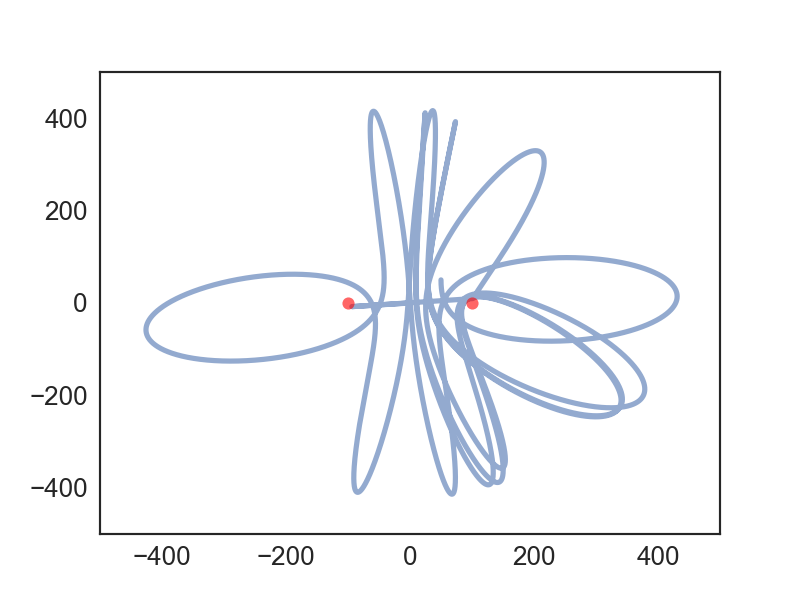

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [31]:
newfig()
plot(system.results.x_p1, system.results.y_p1)
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlim = [-500, 500],
         ylim = [-500, 500])

In [ ]:
type(system.results)

## Useful Stuff here?

In [36]:
#To make the animation faster
#The following line takes every 100th row of the original system.results
resampled = system.results.iloc[::5000, :]

<IPython.core.display.Javascript object>


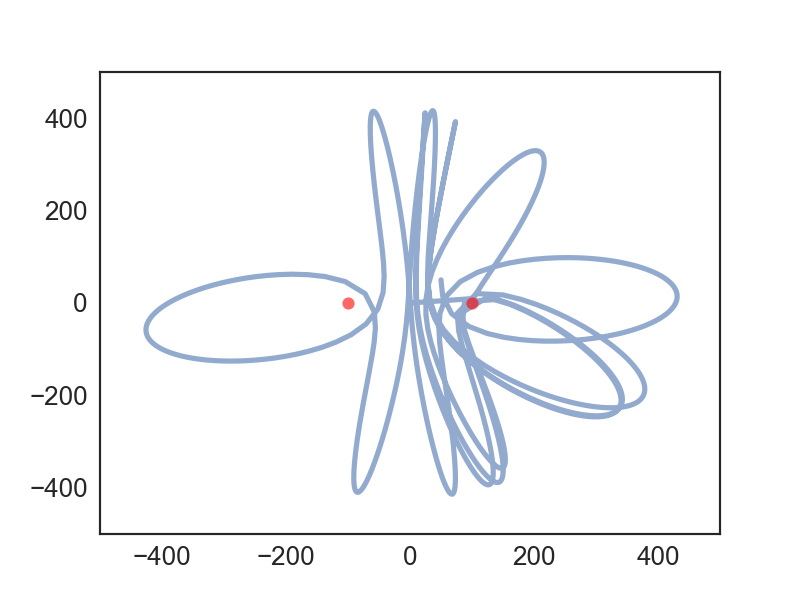

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [37]:
newfig()
plot(resampled.x_p1, resampled.y_p1)
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlim = [-500, 500],
         ylim = [-500, 500])

<IPython.core.display.Javascript object>


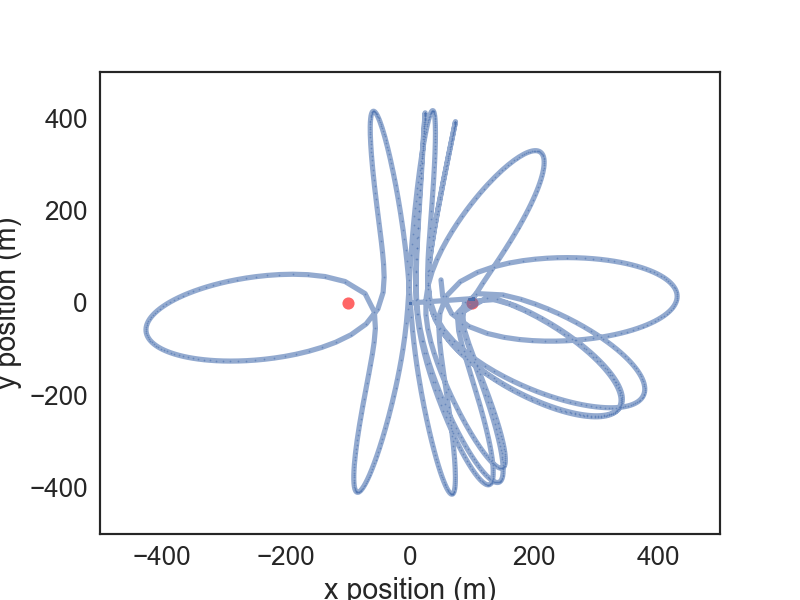

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

In [38]:
newfig()
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim = [-500, 500],
         ylim =[-500, 500],
         legend=False)
x_array = []
y_array = []
for x, y in zip(resampled.x_p1, resampled.y_p1):
    x_array.append(x)
    y_array.append(y)
    plot(x_array, y_array, '-o', markersize=1, update=True)
    #plot(x, y, '-o', update=True)
    #sleep(0.00001)